# SVM Classifier x Toxic Content Detection
Il presente Notebook mostra l'addestramento ed il testing di un Classificatore basato su SVM per il task di Toxic Content Detection.

I dati sono stati processati come segue:
1. Pulizia del testo (si veda, 'dataset_preprocessing.py')
2. Lemmatizzazione con NLTK
3. Vettorizzazione con TF-IDF

In [1]:
import pandas as pd
import pickle
import nltk
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from datetime import datetime
from sklearn.metrics import accuracy_score,precision_score,recall_score, confusion_matrix, ConfusionMatrixDisplay

# Addestramento del Sistema
Il Sistema è ovviamente riaddestrabile a piacere. Si consiglia, tuttavia, dato il tempo necessario per riaddestrare il classificatore, di utilizzare il file pickle 'svm_classifier' per eseguire subito gli esperimenti.

## Caricamento del Training Set

In [2]:
training_set = pd.read_csv("./../../datasets/training_set.csv")
training_set_lem = pd.read_csv("./../../datasets/training_set_lemmatized.csv")

# Osservazione: il Training Set è stato già ripulito
training_set

,comment_text,toxic
0,cocksucker before you piss around on my work,1
1,hey what is it talk what is it an exclusive gr...,1
2,bye dont look come or think of comming back to...,1
3,you are gay or antisemmitian archangel white t...,1
4,fuck your filthy mother in the ass dry,1
...,...,...
30572,chris i dont know who you are talking to but i...,0
30573,operation condor is also named a dirty war can...,0
30574,there is no evidence that this block has anyth...,0
30575,thanks hey utkarshraj thanks for the kindness ...,0


Sia l'addestramento che il testing saranno eseguiti sia sul Dataset "non-lemmatizzato" che sul Dataset "lemmatizzato". Osserviamo immediatamente che lo spazio delle feature del Dataset "lemmatizzato" è inferiore (49188 $<$ 56091) rispetto a quello del Dataset "non-lemmatizzato". Ciò ha impatto sia sul tempo necessario per addestrare il classificatore sia sull'accuracy del modello, come verrà mostrato in seguito.

In [3]:
# Vettorizzazione con TF-IDF
vectorizer = TfidfVectorizer()
vectorizer_lem = TfidfVectorizer()

y_train = training_set['toxic']

X_train = vectorizer.fit_transform(training_set['comment_text'])
X_train_lem = vectorizer_lem.fit_transform(training_set_lem['comment_text'])

print("y_train.shape: " + str(y_train.shape))

print("X_train.shape: " + str(X_train.shape))
print("X_train_lem.shape: " + str(X_train_lem.shape))

y_train.shape: (30577,)
X_train.shape: (30577, 56091)
X_train_lem.shape: (30577, 49188)


## Addestramento del Modello

In [4]:
kernel = 'poly'

model_filename = '{}_svm_classifier.pkl'.format(kernel)
model_lem_filename = '{}_svm_classifier_lem.pkl'.format(kernel)
cl, cl_lem = None, None

Esegui la seguente sottosezione per riaddestrare il Classificatore da capo. Il modello ottenuto verrà persistito nel file '{kernel}_svm_classifier.pkl'.

In [5]:
cl = SVC(kernel=kernel, probability=True, random_state=24)
cl_lem = SVC(kernel=kernel, probability=True, random_state=24)

In [6]:
# Addestramento sul Dataset non-lemmatizzato

print("Training started on not-Lemmatized Dataset...")
start = datetime.now()
cl.fit(X=X_train, y=y_train)
end = datetime.now()
print("Training completed! Required time: " + str(end-start))

with open(model_filename, 'wb') as f:
    pickle.dump(cl, f)

Training started on not-Lemmatized Dataset...
Training completed! Required time: 0:39:35.945919


In [7]:
# Addestramento sul Dataset lemmatizzato

print("Training started on Lemmatized Dataset...")
start = datetime.now()
cl_lem.fit(X=X_train_lem, y=y_train)
end = datetime.now()
print("Training completed! Required time: " + str(end-start))

with open(model_lem_filename, 'wb') as f:
    pickle.dump(cl_lem, f)

Training started on Lemmatized Dataset...
Training completed! Required time: 0:36:53.807161


Esegui la seguente sottosezione per utilizzare il Classificatore già addestrato.

In [8]:
with open(model_filename, 'rb') as f:
    cl = pickle.load(f)

In [9]:
with open(model_lem_filename, 'rb') as f:
    cl_lem = pickle.load(f)

# Testing del Sistema

In [10]:
test_data = pd.read_csv("./../../datasets/test_set.csv")
test_data_lem = pd.read_csv("./../../datasets/test_set_lemmatized.csv")

test_data.dropna(inplace=True)
test_data_lem.dropna(inplace=True)

In [11]:
test_set = test_data[test_data['toxic'] != -1]
other_set = test_data[test_data['toxic'] == -1]

test_set_lem = test_data_lem[test_data_lem['toxic'] != -1]
other_set_lem = test_data_lem[test_data_lem['toxic'] == -1]

In [12]:
y_test = test_set['toxic']
print("y_test.shape: " + str(y_test.shape))

y_test.shape: (63842,)


In [13]:
X_test = vectorizer.transform(test_set['comment_text'])
print("X_test.shape: " + str(X_test.shape))

X_test.shape: (63842, 56091)


In [14]:
X_test_lem = vectorizer_lem.transform(test_set_lem['comment_text'])
print("X_test_lem.shape: " + str(X_test_lem.shape))

X_test_lem.shape: (63842, 49188)


Predizioni sul Test Set non-Lemmatizzato

In [15]:
y_pred = cl.predict(X_test)

#Metriche: Accuracy,Precision,Recall
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))

Accuracy: 0.8468876288336832
Precision: 0.36712782821732237
Recall: 0.8370297355018893


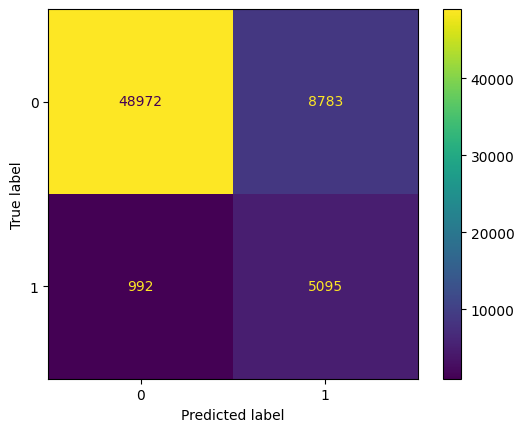

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=cl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cl.classes_)
disp.plot()
plt.show()

Predizioni sul Test Set Lemmatizzato

In [17]:
y_pred_lem = cl_lem.predict(X_test_lem)

#Metriche: Accuracy,Precision,Recall
print("Accuracy: " + str(accuracy_score(y_test, y_pred_lem)))
print("Precision: " + str(precision_score(y_test, y_pred_lem)))
print("Recall: " + str(recall_score(y_test, y_pred_lem)))

Accuracy: 0.8432066664578177
Precision: 0.3632243218743463
Recall: 0.8557581731559061


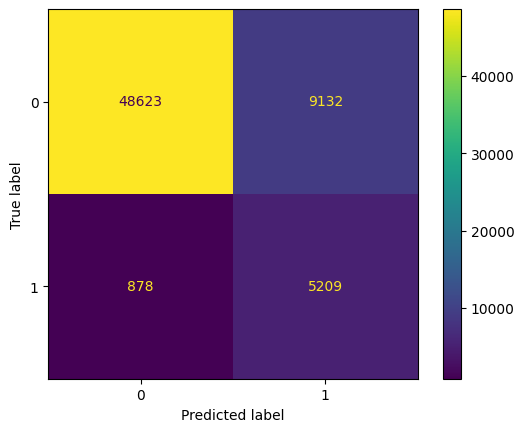

In [18]:
cm = confusion_matrix(y_test, y_pred_lem, labels=cl_lem.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cl_lem.classes_)
disp.plot()
plt.show()

### Funzioni di Supporto
Da utilizzare qualora si volesse effettuare una predizione su una frase "inedita".

In [19]:
# Pulizia della Frase
def clean_phrases(phrases):
    new_phrases = list()
    for phrase in phrases:
        # Rimozione di "\r" e "\n"
        phrase = re.sub(r'[\r\n]+', '', phrase)
        # Rimozione di sequenze di ":" (esempio, "::::")
        phrase = re.sub(r'::+', '', phrase)
        # Rimozione di sequenze di "=" (esempio, "====")
        phrase = re.sub(r'==+', '', phrase)
        # Rimozione di sequenze di "*" (esempio, "**")
        phrase = re.sub(r'\*\*+', '', phrase)
        # Rimozione di sequenze numeriche in formato di indirizzi IP (esempio, "192.168.1.1")
        phrase = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '', phrase)
        # Rimozione di contenuto compreso tra Parentesi Quadre (esempio, "[contentContent]")
        phrase = re.sub(r'\[[^\[\]]+\]', '', phrase)
        # Rimozione di Apici, sia singoli che doppi
        phrase = re.sub(r"['\"]", "", phrase)

        ## La rimozione di particolari caratteri o sequenze di caratteri può portare alla fusione di due token diversi

        # Splitting di token in cui compare un segno di interpuzione forte ("?", "!" e ".") seguito da una lettera maiuscola
        phrase = re.sub(r'([?!\.])([A-Z]\w*)', r'\1 \2', phrase)
        # Splitting di parole fuse (esempio, "parolaParola" diventa "parola Parola")
        phrase = re.sub(r'([a-z])([A-Z])', r'\1 \2', phrase)

        tokens = word_tokenize(phrase)
        lowercase_tokens = [token.lower() for token in tokens if token.isalpha()]
        new_phrases.append(' '.join(lowercase_tokens))
    
    return new_phrases

In [20]:
# Lemmatizzazione della Frase
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    lemmatized_text = []
    for token, tag in tagged_tokens:
        pos = get_wordnet_pos(tag)
        lemmatized_token = lemmatizer.lemmatize(token, pos=pos)
        lemmatized_text.append(lemmatized_token)
    return ' '.join(lemmatized_text)

Esempio:

In [21]:
text = "Today I went to the office at 9 o'clock and there were a lot of people."

In [22]:
# nltk.download('wordnet')
# nltk.download('punkt')

In [23]:
phrases = clean_phrases([text])

string = phrases[0]
lemmatized_string = lemmatize_text(phrases[0])

In [24]:
string_to_vec = vectorizer.transform([string])
lem_string_to_vec = vectorizer_lem.transform([lemmatized_string])

In [25]:
#predict_proba calcola la probabilità di ogni etichetta
print(str(cl.predict(string_to_vec)) + " -> " + str(cl.predict_proba(string_to_vec)))
print(str(cl_lem.predict(lem_string_to_vec)) + " -> " + str(cl_lem.predict_proba(lem_string_to_vec)))

[0] -> [[0.78706893 0.21293107]]
[0] -> [[0.73779487 0.26220513]]
